IMPORT PACKAGE

In [35]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.data import random_split
from torch.optim import Adam
import torchvision
from torchvision import transforms
import time
from tqdm import tqdm
from skimage.io import imsave, imread

IMPORT DATA DARI GOOGLE DRIVE

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
from PIL import Image
import os 
import numpy as np

# define train and validation data path
train_data_path = '/content/drive/MyDrive/Colab Notebooks/datasets/tomato custom/train'
test_data_path = '/content/drive/MyDrive/Colab Notebooks/datasets/tomato custom/val'

IMPORT DATA DARI GITHUB

In [22]:
!apt-get install subversion > /dev/null

!svn export https://github.com/DwiWahyuEffendi/Tomato-Disease-Classification/trunk/tomato_custom/ > /dev/null  --force

In [33]:
!ls tomato_custom
!ls tomato_custom/train
!ls tomato_custom/val
#!ls tomato_custom/train/Tomato___Bacterial_spot

train  val
 Tomato___Bacterial_spot   Tomato___Septoria_leaf_spot
 Tomato___Early_blight	  'Tomato___Spider_mites Two-spotted_spider_mite'
 Tomato___healthy	   Tomato___Target_Spot
 Tomato___Late_blight	   Tomato___Tomato_mosaic_virus
 Tomato___Leaf_Mold	   Tomato___Tomato_Yellow_Leaf_Curl_Virus
 Tomato___Bacterial_spot   Tomato___Septoria_leaf_spot
 Tomato___Early_blight	  'Tomato___Spider_mites Two-spotted_spider_mite'
 Tomato___healthy	   Tomato___Target_Spot
 Tomato___Late_blight	   Tomato___Tomato_mosaic_virus
 Tomato___Leaf_Mold	   Tomato___Tomato_Yellow_Leaf_Curl_Virus


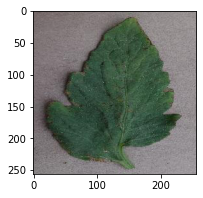

In [36]:
image = imread("tomato_custom/train/Tomato___Bacterial_spot/33950b17-918e-4243-bfbd-be33874b62c4___GCREC_Bact.Sp 3303.JPG")
plt.figure(figsize=(3,3))
plt.imshow(image)

In [37]:
from PIL import Image
import os 
import numpy as np

# define train and validation data path
train_data_path = 'tomato_custom/train'
test_data_path = 'tomato_custom/val'

In [38]:
# define the hyperparameters
batch_size = 10
train_split = 0.90
val_split = 1 -  train_split

In [39]:
# define the transformations done on the dataset
transform = transforms.Compose([
    transforms.Resize(64),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4518, 0.4638, 0.4181],
    std=[0.1836, 0.1602, 0.1991])
])

In [40]:
# load the initial data
initial_data = torchvision.datasets.ImageFolder(
    root=train_data_path, 
    transform=transform
)

test_data = torchvision.datasets.ImageFolder(
    root=test_data_path, 
    transform=transform
)

In [41]:
print(len(initial_data))

6691


In [42]:
# split the initial data into train and test sets
len_init = len(initial_data) - 1
train_len = int(len_init * train_split)
val_len = int(len_init * val_split) + 2
train_data, val_data = random_split(initial_data, [train_len, val_len], generator=torch.Generator().manual_seed(42))

In [43]:
# load the train, val and test sets

train_loader = DataLoader(
  train_data, 
  batch_size=batch_size, 
  shuffle=False
)

test_loader = DataLoader(
  test_data, 
  batch_size=batch_size, 
  shuffle=False
)

val_loader = DataLoader(
  val_data, 
  batch_size=batch_size, 
  shuffle=False
)

In [44]:
print(len(train_loader.dataset), len(val_loader.dataset), len(test_loader.dataset))

6021 670 806


In [45]:
# compute steps per epoch for training and validation set
train_steps = len(train_loader.dataset) // batch_size
val_steps = len(val_loader.dataset) // batch_size

## 2. Define the model

In [46]:
class TomatoDiseaseCNN(nn.Module):
    '''
        Convolutional Neural Network for tomato disease classification
    '''
    def __init__(self, in_channels=3, num_classes=10):
        super(TomatoDiseaseCNN, self).__init__()
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=1, padding=1)
        self.act1 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.act2 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=1, padding=1)
        self.act3 = nn.ReLU()
        self.pool3 = nn.MaxPool2d(kernel_size=2)
        self.fc1 = nn.Linear(128*8*8, 256)
        self.act4 = nn.ReLU()
        self.fc2 = nn.Linear(256, num_classes)
        self.act5 = nn.Softmax(dim=1)

    def forward(self, x):
        x = self.conv1(x)
        x = self.act1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.act2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.act3(x)
        x = self.pool3(x)
        x = x.view(-1, 128*8*8)
        x = self.fc1(x)
        x = self.act4(x)
        x = self.fc2(x)
        x = self.act5(x)
        return x

In [47]:
# choose the device on which we can train the mode
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = TomatoDiseaseCNN(3, 10).to(device)
# define the loss and the optimier
criterion = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=0.001)

## 3. Train the model

In [48]:
# define train model 
def train_model(model, optimizer, loss_fn, train_loader, val_loader, epochs=10, device=device):
    # initialize the dict to store the history of the model
    history = {
        "train_loss": [],
        "train_acc": [],
        "val_loss": [],
        "val_acc": []
    }
    for epoch in range(epochs):
        # set the model in training mode
        model.train()
        # initialise the training and validation loss
        train_loss, val_loss = 0, 0
        # initialize numbers of correct train and correct validation
        correct_train, correct_val = 0, 0
        for data, target in tqdm(train_loader,  ascii ="  ...="):
            data = data.to(device)
            target = target.to(device)
            # set parameters gradients to zero
            optimizer.zero_grad()
            # forward pass
            output = model(data)
            # compute the loss
            loss = loss_fn(output, target)
            # compute the loss gradients w. r. t. parameters
            loss.backward()
            # update the parameters
            optimizer.step()
            train_loss += loss
            # _, correct = output.max(1)
            # correct_train += (correct == target).sum()
            correct_train +=(output.argmax(1) ==target).type(torch.float).sum().item()
        with torch.no_grad():
            # set the model in evaluation mode
            model.eval()
            for data, target in val_loader:
                data = data.to(device)
                target = target.to(device)
                # forward from validation data
                output = model(data)
                loss = loss_fn(output, target)
                val_loss += loss
                correct_val +=(output.argmax(1) ==target).type(torch.float).sum().item()
        # compute the average of traning and validation loss
        train_loss_avg = train_loss / train_steps
        # training_loss /= len(train_loader)
        val_loss_avg = val_loss / val_steps
        # valid_loss /= len(val_loader)

        # compute the accuracy of training and validation set
        # calculate the training and validation accuracy
        correct_train = correct_train / len(train_loader.dataset)
        correct_val = correct_val / len(val_loader.dataset)
        # update our training history
        history["train_loss"].append(train_loss_avg.cpu().detach().numpy())
        history["train_acc"].append(correct_train)
        history["val_loss"].append(val_loss_avg.cpu().detach().numpy())
        history["val_acc"].append(correct_val)

        # print the model training and validation information
        print("Epoch: {}/{}".format(epoch + 1, epochs))
        print("train loss: {:.6f} - train accuracy: {:.4f}".format(train_loss_avg, correct_train))
        print("val loss: {:.6f} - val accuracy: {:.4f}".format(val_loss_avg, correct_val))
    return history

In [55]:
# train and check the time of training
start_time = time.time()
history = train_model(model, optimizer, criterion, train_loader, val_loader, 80)
end_time = time.time()
print("The model took {:.2f}s for training : ".format(end_time - start_time))

100%|==========| 603/603 [00:56<00:00, 10.68it/s]


Epoch: 1/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.76it/s]


Epoch: 2/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.71it/s]


Epoch: 3/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.69it/s]


Epoch: 4/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.67it/s]


Epoch: 5/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.69it/s]


Epoch: 6/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.74it/s]


Epoch: 7/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.70it/s]


Epoch: 8/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.64it/s]


Epoch: 9/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.69it/s]


Epoch: 10/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.73it/s]


Epoch: 11/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.67it/s]


Epoch: 12/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.70it/s]


Epoch: 13/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.70it/s]


Epoch: 14/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.69it/s]


Epoch: 15/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.70it/s]


Epoch: 16/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.66it/s]


Epoch: 17/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.66it/s]


Epoch: 18/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:57<00:00, 10.57it/s]


Epoch: 19/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.66it/s]


Epoch: 20/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.67it/s]


Epoch: 21/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.67it/s]


Epoch: 22/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.70it/s]


Epoch: 23/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.63it/s]


Epoch: 24/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.61it/s]


Epoch: 25/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.73it/s]


Epoch: 26/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.69it/s]


Epoch: 27/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.66it/s]


Epoch: 28/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.59it/s]


Epoch: 29/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.62it/s]


Epoch: 30/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.58it/s]


Epoch: 31/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:57<00:00, 10.58it/s]


Epoch: 32/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.59it/s]


Epoch: 33/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:56<00:00, 10.58it/s]


Epoch: 34/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:57<00:00, 10.51it/s]


Epoch: 35/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:57<00:00, 10.51it/s]


Epoch: 36/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:57<00:00, 10.49it/s]


Epoch: 37/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:57<00:00, 10.52it/s]


Epoch: 38/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:57<00:00, 10.58it/s]


Epoch: 39/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:57<00:00, 10.55it/s]


Epoch: 40/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:57<00:00, 10.46it/s]


Epoch: 41/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:57<00:00, 10.47it/s]


Epoch: 42/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:57<00:00, 10.54it/s]


Epoch: 43/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:57<00:00, 10.47it/s]


Epoch: 44/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:57<00:00, 10.43it/s]


Epoch: 45/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:57<00:00, 10.44it/s]


Epoch: 46/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:57<00:00, 10.43it/s]


Epoch: 47/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:58<00:00, 10.37it/s]


Epoch: 48/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:58<00:00, 10.39it/s]


Epoch: 49/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:58<00:00, 10.37it/s]


Epoch: 50/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:58<00:00, 10.32it/s]


Epoch: 51/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:58<00:00, 10.35it/s]


Epoch: 52/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:58<00:00, 10.28it/s]


Epoch: 53/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:58<00:00, 10.23it/s]


Epoch: 54/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:58<00:00, 10.26it/s]


Epoch: 55/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:58<00:00, 10.22it/s]


Epoch: 56/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:58<00:00, 10.24it/s]


Epoch: 57/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:59<00:00, 10.16it/s]


Epoch: 58/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:59<00:00, 10.08it/s]


Epoch: 59/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [00:59<00:00, 10.09it/s]


Epoch: 60/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [01:00<00:00,  9.95it/s]


Epoch: 61/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [01:01<00:00,  9.88it/s]


Epoch: 62/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [01:01<00:00,  9.75it/s]


Epoch: 63/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [01:02<00:00,  9.63it/s]


Epoch: 64/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [01:03<00:00,  9.52it/s]


Epoch: 65/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [01:04<00:00,  9.40it/s]


Epoch: 66/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [01:05<00:00,  9.25it/s]


Epoch: 67/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [01:07<00:00,  9.00it/s]


Epoch: 68/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [01:08<00:00,  8.86it/s]


Epoch: 69/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [01:09<00:00,  8.71it/s]


Epoch: 70/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [01:10<00:00,  8.52it/s]


Epoch: 71/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [01:12<00:00,  8.31it/s]


Epoch: 72/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [01:15<00:00,  8.04it/s]


Epoch: 73/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [01:16<00:00,  7.84it/s]


Epoch: 74/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [01:18<00:00,  7.66it/s]


Epoch: 75/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [01:21<00:00,  7.43it/s]


Epoch: 76/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [01:23<00:00,  7.24it/s]


Epoch: 77/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [01:25<00:00,  7.05it/s]


Epoch: 78/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [01:27<00:00,  6.91it/s]


Epoch: 79/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194


100%|==========| 603/603 [01:29<00:00,  6.76it/s]


Epoch: 80/80
train loss: 2.343979 - train accuracy: 0.1212
val loss: 2.341747 - val accuracy: 0.1194
The model took 5113.59s for training : 


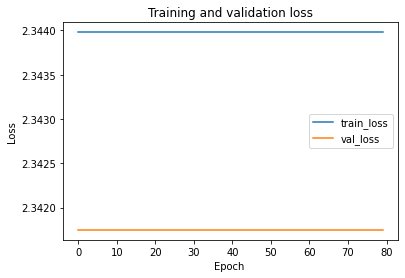

In [56]:
plt.plot(history["train_loss"], label="train_loss")
plt.plot(history["val_loss"], label="val_loss")
plt.title("Training and validation loss")
plt.xlabel("Epoch ")
plt.ylabel("Loss")
plt.legend(loc="best")
plt.show()

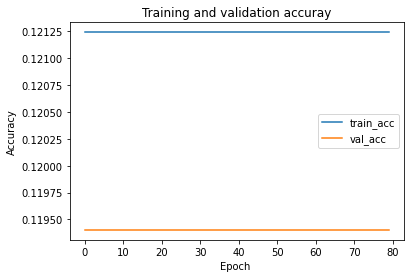

In [57]:
plt.plot(history["train_acc"], label="train_acc")
plt.plot(history["val_acc"], label="val_acc")
plt.title("Training and validation accuray")
plt.xlabel("Epoch ")
plt.ylabel("Accuracy")
plt.legend(loc="best")
plt.show()

## 4. Evaluate the model

In [52]:
# define the function to evaluate the model
def evaluate(data_loader):
    # forbide the computation of grandient: autograd
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        pred_targets = []
        for data, _ in tqdm(data_loader,  ascii ="  ...="):
            data = data.to(device)
            pred_target = model(data)
            pred_targets.extend(pred_target.argmax(axis=1).cpu().numpy())
    return pred_targets

In [53]:
# display metrics
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np
targets_hat = evaluate(test_loader)
print(classification_report(test_data.targets, np.array(targets_hat), target_names=test_data.classes))

100%|==========| 81/81 [00:03<00:00, 22.14it/s]

                                               precision    recall  f1-score   support

                      Tomato___Bacterial_spot       0.00      0.00      0.00        85
                        Tomato___Early_blight       0.00      0.00      0.00        81
                         Tomato___Late_blight       0.00      0.00      0.00        83
                           Tomato___Leaf_Mold       0.09      1.00      0.17        74
                  Tomato___Septoria_leaf_spot       0.00      0.00      0.00        86
Tomato___Spider_mites Two-spotted_spider_mite       0.00      0.00      0.00        83
                         Tomato___Target_Spot       0.00      0.00      0.00        77
       Tomato___Tomato_Yellow_Leaf_Curl_Virus       0.00      0.00      0.00        77
                 Tomato___Tomato_mosaic_virus       0.00      0.00      0.00        81
                             Tomato___healthy       0.00      0.00      0.00        79

                                     accu


/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


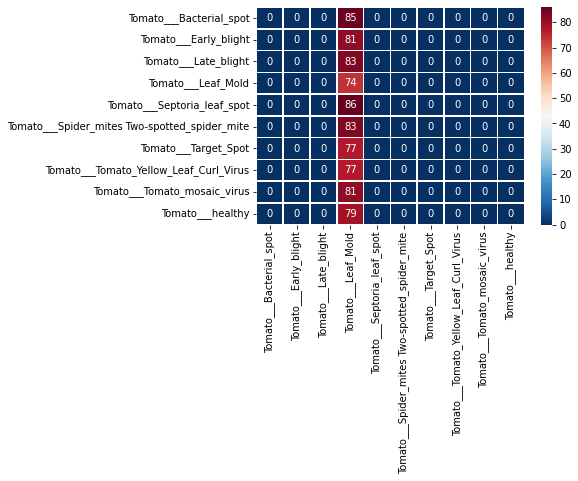

In [54]:
sns.heatmap(confusion_matrix(test_data.targets, targets_hat), 
             xticklabels=test_data.classes,
             yticklabels=test_data.classes,
             cmap='RdBu_r',
             annot=True,
             linewidth=0.5)
